In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from util.data import read_data

countries, data = read_data(update=False)
regions_ru = countries[countries['is_region'] == 1]
data_ru = data[data['country'].isin(regions_ru.index)]

data_ru.head()

,date,country,confirmed,deaths
6499,2020-03-28,RU-AD,1,0
6500,2020-03-29,RU-AD,1,0
6501,2020-03-30,RU-AD,4,0
6502,2020-03-31,RU-AD,4,0
6503,2020-04-01,RU-AD,4,0


In [2]:
# Число дней, за которые считаем прирост случаев заражения
VALIDATE_DAYS = 7
VALIDATE_DATE_FROM = data_ru['date'].max() - pd.to_timedelta(VALIDATE_DAYS - 1, unit='d')

# Число дней, за которые считаем средний индекс самоизоляции
ISOLATE_DAYS = 7
ISOLATE_DATE_FROM = VALIDATE_DATE_FROM - pd.to_timedelta(ISOLATE_DAYS, unit='d')

# Отбросим регионы с малым числом случаев
confirmed_ru = data_ru[data_ru['date'] == VALIDATE_DATE_FROM][['country', 'confirmed']].set_index('country')
data_ru = data_ru[data_ru['country'].isin(confirmed_ru[confirmed_ru['confirmed'] > 50].index)]

data_ru_train = data_ru[data_ru['date'] < VALIDATE_DATE_FROM]

# Распределение индекса самоизоляции по регионам

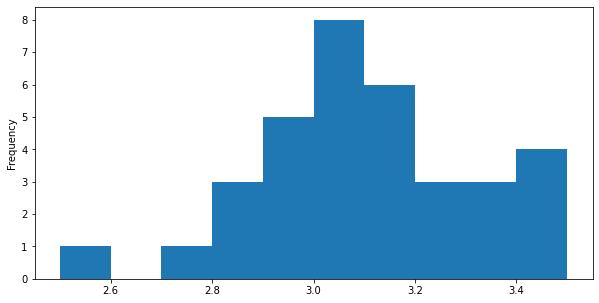

In [3]:
isolation = pd.read_csv('data/mobility-yandex.csv', parse_dates=['date'])
isolation_range = isolation[(isolation['date'] >= ISOLATE_DATE_FROM) & (isolation['date'] < VALIDATE_DATE_FROM)]
isolation_range = isolation_range[isolation_range['country'].isin(data_ru['country'].unique())]
isolation_mean = isolation_range.groupby('country')['isolation'].mean().round(1)
isolation_mean.plot.hist(bins=10, figsize=(10, 5))

# Зависимость роста заражений от индекса самоизоляции

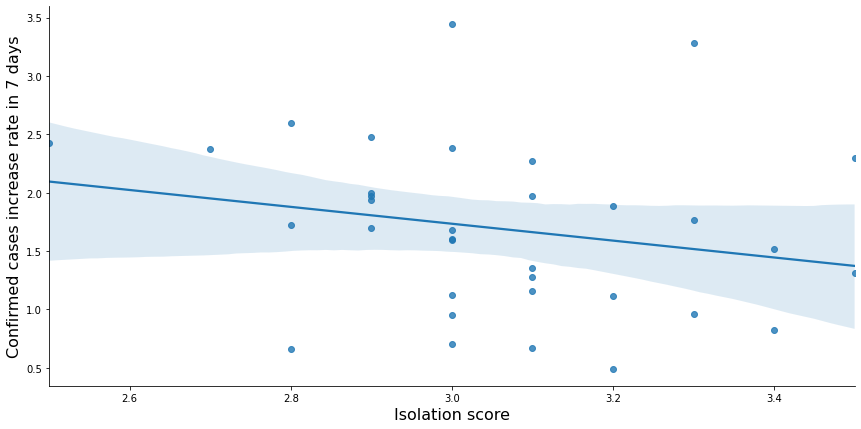

In [4]:
data_from = data_ru[data_ru['date'] == VALIDATE_DATE_FROM][['country', 'confirmed']].set_index('country')
data_to = data_ru[data_ru['date'] == data_ru['date'].max()][['country','confirmed']].set_index('country')

confirmed_increase = (data_to - data_from) / data_from
isolation_score = pd.merge(confirmed_increase, isolation_mean, how='inner', on='country')[['confirmed', 'isolation']]

sns.lmplot(x='isolation', y='confirmed', data=isolation_score, fit_reg=True, height=6, aspect=2)
plt.xlabel('Isolation score', fontsize=16)
plt.ylabel(f'Confirmed cases increase rate in {VALIDATE_DAYS} days', fontsize=16)
plt.show()